In [1]:
import boto3
import os
import json
import base64
from PIL import Image
import pandas as pd
import numpy as np

In [2]:
def setup_environment():
    import sys
    sys.path.append('C:\\gitworkspace\\aimldemo\\jupyterworkapce')
    import stratup_env_setup
    stratup_env_setup.set_env()

In [3]:
setup_environment()

In [4]:
 s3_client = boto3.client('s3')

In [5]:
response = s3_client.list_buckets()

In [6]:
    if 'Buckets' in response:
        print("S3 Buckets in your account:")
        for bucket in response['Buckets']:
            print(f"- {bucket['Name']}")
    else:
        print("No buckets found.")

S3 Buckets in your account:
- aws-cloudtrail-logs-312296519090-783817be
- aws-emr-resources-312296519090-us-east-1
- aws-logs-312296519090-us-east-1
- elasticbeanstalk-us-east-1-312296519090
- elasticbeanstalk-us-east-2-312296519090
- sagemaker-studio-o5xeslsirg
- sagemaker-us-east-1-312296519090
- test-s3-jj-bucket


# Amazon Titan Model

In [7]:
bedrock = boto3.client(region_name="us-east-1", service_name='bedrock')

In [8]:
bedrock.list_foundation_models()

{'ResponseMetadata': {'RequestId': '5e9e432b-9892-4345-b0b5-6632f11c00ce',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Mon, 23 Sep 2024 16:40:23 GMT',
   'content-type': 'application/json',
   'content-length': '28599',
   'connection': 'keep-alive',
   'x-amzn-requestid': '5e9e432b-9892-4345-b0b5-6632f11c00ce'},
  'RetryAttempts': 0},
 'modelSummaries': [{'modelArn': 'arn:aws:bedrock:us-east-1::foundation-model/amazon.titan-tg1-large',
   'modelId': 'amazon.titan-tg1-large',
   'modelName': 'Titan Text Large',
   'providerName': 'Amazon',
   'inputModalities': ['TEXT'],
   'outputModalities': ['TEXT'],
   'responseStreamingSupported': True,
   'customizationsSupported': [],
   'inferenceTypesSupported': ['ON_DEMAND'],
   'modelLifecycle': {'status': 'ACTIVE'}},
  {'modelArn': 'arn:aws:bedrock:us-east-1::foundation-model/amazon.titan-image-generator-v1:0',
   'modelId': 'amazon.titan-image-generator-v1:0',
   'modelName': 'Titan Image Generator G1',
   'providerName': 'Amazon',

In [9]:
bedrock.get_foundation_model(modelIdentifier='amazon.titan-text-express-v1')

{'ResponseMetadata': {'RequestId': '7fd39360-17df-427a-986a-594e38d6d8ac',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Mon, 23 Sep 2024 16:40:23 GMT',
   'content-type': 'application/json',
   'content-length': '429',
   'connection': 'keep-alive',
   'x-amzn-requestid': '7fd39360-17df-427a-986a-594e38d6d8ac'},
  'RetryAttempts': 0},
 'modelDetails': {'modelArn': 'arn:aws:bedrock:us-east-1::foundation-model/amazon.titan-text-express-v1',
  'modelId': 'amazon.titan-text-express-v1',
  'modelName': 'Titan Text G1 - Express',
  'providerName': 'Amazon',
  'inputModalities': ['TEXT'],
  'outputModalities': ['TEXT'],
  'responseStreamingSupported': True,
  'customizationsSupported': [],
  'inferenceTypesSupported': ['ON_DEMAND'],
  'modelLifecycle': {'status': 'ACTIVE'}}}

In [10]:
bedrock_runtime = boto3.client(region_name="us-east-1",
                               service_name='bedrock-runtime')

Thus, the Titan model expects the following jsonified request body:
```
{
    "inputText": string,
    "textGenerationConfig": {
        "temperature": float,  
        "topP": float,
        "maxTokenCount": int,
        "stopSequences": [string]
    }
}
```

In [11]:
question = "What is the capital of New Jersey?"

In [12]:
body = json.dumps({
    "inputText": question,
})
print(body)

{"inputText": "What is the capital of New Jersey?"}


In [13]:
response = bedrock_runtime.invoke_model(body=body, modelId="amazon.titan-text-lite-v1")

In [14]:
response_body = json.loads(response.get('body').read())
response_body

{'inputTextTokenCount': 8,
 'results': [{'tokenCount': 23,
   'outputText': '\nTrenton is the capital of New Jersey. It is also the largest city in the state. ',
   'completionReason': 'FINISH'}]}

# LLama 2

Llama 2 accept the following parameters:

- `prompt`: string
  - This represents the initial text or question provided to the system.
- `temperature`: float
  - This controls the randomness in the text generation process. A higher temperature results in more random outputs, while a lower temperature produces more predictable text.
- `top_p`: float
  - This parameter, also known as "nucleus sampling," controls the diversity of the generated text. It sets a threshold to include the most likely next words, cumulatively adding up to the specified probability 'P'. A lower value ignores less probable options. Set to 0 or 1.0 to disable
- `max_gen_len`: int
  - This specifies the maximum number of tokens that the generated text can contain.
   
Thus, the model expects the following jsonified request body:
```
{
    "prompt": "string",
    "temperature": float,
    "top_p": float,
    "max_gen_len": int
}
```

Default Values:


| Category              | Parameter            | JSON object format | Minimum | Maximum | Default |
|-----------------------|----------------------|--------------------|---------|---------|---------|
| Randomness and diversity | Temperature        | `temperature`      | 0       | 1       | 0.5     |
|                       | Top P               | `top_p`            | 0       | 1       | 0.9     |
| Length                | Max generation length| `max_gen_len`      | 1       | 2048    | 512     |

In [15]:
prompt = "Explain about Piscataway, NJ"

In [16]:
body = json.dumps({
    "prompt": prompt,
    "max_gen_len": 256,
    "temperature": 0.9,  # Let's push it to be creative
    "top_p": 0.9,
})


In [17]:
response = bedrock_runtime.invoke_model(body=body, modelId="meta.llama3-8b-instruct-v1:0")
response_body = json.loads(response.get('body').read())
response_body

{'generation': "?\nPiscataway, New Jersey is a township located in Middlesex County, New Jersey, United States. As of the 2020 United States Census, the township's population was 56,145.\nPiscataway is a diverse community with a mix of residential neighborhoods, commercial areas, and educational institutions. The township is home to several parks, including the Piscataway Community Park, which offers recreational facilities, playgrounds, and walking trails.\nPiscataway is also known for its rich history and cultural attractions. The township is home to the Piscataway Historical Society, which preserves and interprets the history of the area. The township is also home to the Middlesex County Museum, which features exhibits on the history and culture of the region.\nIn addition to its cultural attractions, Piscataway is also home to several educational institutions, including Rutgers, The State University of New Jersey, which has a campus located in the township. The township is also hom

# PDF RAG

In [18]:
#!pip install PyPDF2

In [19]:
file_name = 'Corporate_Travel_Policy.pdf'

In [20]:
from PyPDF2 import PdfReader

In [21]:
reader = PdfReader(file_name)

In [22]:
page = reader.pages[0]

In [23]:
text = page.extract_text().replace('\n',' ')

In [24]:
text

"Corporate Travel and Time Off Policy Introduction This policy establishes clear guidelines and procedures for time off and corporate travel for employees. It aims to ensure fair and consistent application throughout the organization while supporting operational needs. Annual Paid Time Off (PTO) Entitlement ● PTO Allocation: All employees receive five weeks (25 working days) of PTO per calendar year . ● Accrual of PTO: PTO accrues monthly based on the annual entitlement. ● Carryover: Unused PTO cannot be carried over to the next year . Employees are encouraged to utilize their PTO within the accrual year . Time Off Beyond PTO ● Managerial Approval: Additional time off beyond the allocated five weeks requires prior approval from the employee's direct manager . ● Request Procedure: Submit time off requests at least four weeks in advance for any period exceeding annual PTO. ● Considerations for Approval: Managers will assess the operational impact, employee performance and attendance, and

In [25]:
query = "How many working days of PTO do employees get per year?"

In [26]:
prompt = f"Answer the following question: {query}. Here is the reference text:\n{text}"

In [27]:
body = json.dumps({
    "inputText": prompt,
    "textGenerationConfig": {
        "temperature": 0,
        "maxTokenCount": 4096
    }
})

In [28]:
response = bedrock_runtime.invoke_model(body=body, modelId="amazon.titan-text-lite-v1")
response_body = json.loads(response.get('body').read())
print(response_body["results"][0]["outputText"])


Based on the provided content, employees receive five weeks (25 working days) of PTO per calendar year.


# Image Generation

In [29]:
#prompt = "A photorealistic image of an apple."
prompt = "Brooklyn bridge with lights in the night"

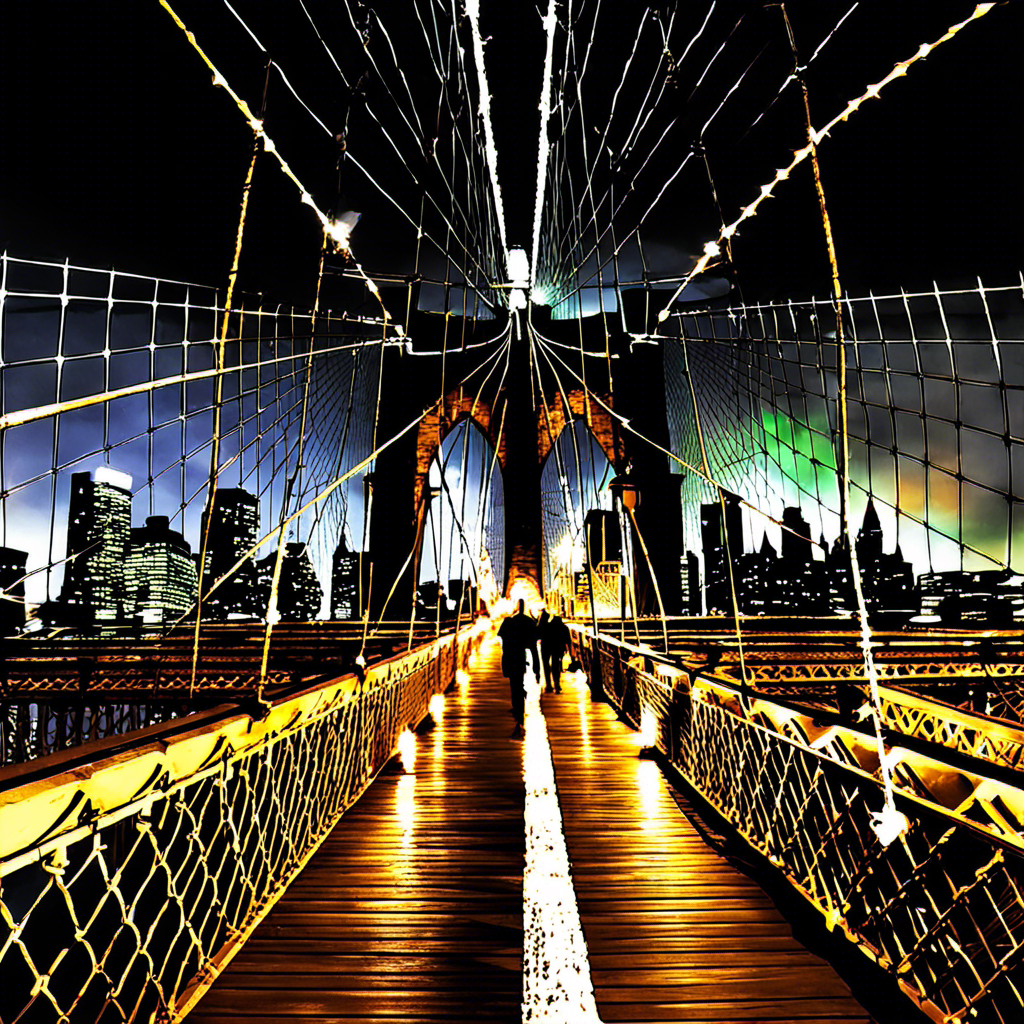

In [30]:
request_body = json.dumps({
        "text_prompts": [
        {
        "text": prompt
        }
    ],
    "cfg_scale": 20,  # High cfg_scale
    "seed": 0,  # Use a seed for reproducability
    "samples" : 1,
    })

response_high_cfg = bedrock_runtime.invoke_model(body=request_body, modelId="stability.stable-diffusion-xl-v1")
response_body_high_cfg = json.loads(response_high_cfg.get('body').read())
base64_image_data_high_cfg = base64.b64decode(response_body_high_cfg["artifacts"][0]["base64"])

file_path = "image2.png"
with open(file_path, "wb") as file:
    file.write(base64_image_data_high_cfg)

Image.open("image2.png")

# Text Embedding/cosine_similarity

In [31]:
sports_text = "Let's go to the baseball game and watch some sports!"
finance_text = "The stock market was way down today, I'm going to lose money!"

In [32]:
json_request = {"inputText": "this is where you place your input text"} 

In [33]:
body = json.dumps(json_request)
print(body)

{"inputText": "this is where you place your input text"}


In [34]:
response = bedrock_runtime.invoke_model(body=body,modelId="amazon.titan-embed-text-v1")

In [35]:
response

{'ResponseMetadata': {'RequestId': 'd6296eb9-a4e6-4832-964b-e88f5401f417',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Mon, 23 Sep 2024 16:40:48 GMT',
   'content-type': 'application/json',
   'content-length': '18263',
   'connection': 'keep-alive',
   'x-amzn-requestid': 'd6296eb9-a4e6-4832-964b-e88f5401f417',
   'x-amzn-bedrock-invocation-latency': '87',
   'x-amzn-bedrock-input-token-count': '8'},
  'RetryAttempts': 0},
 'contentType': 'application/json',
 'body': <botocore.response.StreamingBody at 0x2328a326fe0>}

In [36]:
response_body = json.loads(response.get('body').read())

In [37]:
response_body

{'embedding': [0.91796875,
  0.28125,
  -0.53515625,
  0.66796875,
  -0.93359375,
  -0.41015625,
  -0.064453125,
  -0.000492095947265625,
  0.423828125,
  -0.3828125,
  -0.1494140625,
  -0.169921875,
  -0.384765625,
  0.16796875,
  -0.142578125,
  -0.3671875,
  0.251953125,
  0.306640625,
  -0.1162109375,
  0.1259765625,
  -1.5703125,
  0.10400390625,
  0.04345703125,
  0.267578125,
  0.08447265625,
  -0.099609375,
  -0.04248046875,
  -0.55859375,
  1.125,
  -0.486328125,
  0.62890625,
  0.72265625,
  0.04541015625,
  0.65234375,
  -0.8828125,
  -0.01806640625,
  0.7265625,
  -0.54296875,
  0.80859375,
  -0.18359375,
  -0.0023193359375,
  0.478515625,
  0.03369140625,
  -0.06298828125,
  -0.66796875,
  0.061279296875,
  0.0927734375,
  0.515625,
  0.57421875,
  0.1591796875,
  0.016845703125,
  0.0225830078125,
  -0.3984375,
  0.59375,
  0.57421875,
  0.88671875,
  -0.1396484375,
  0.609375,
  0.703125,
  0.400390625,
  -0.59375,
  -0.53125,
  -0.7109375,
  -0.44140625,
  0.21875,
  0.

In [38]:
len(response_body['embedding'])

1536

In [39]:
def embed_text(text):
    json_request = {"inputText": text} 
    body = json.dumps(json_request)
    response = bedrock_runtime.invoke_model(body=body,modelId="amazon.titan-embed-text-v1")
    return json.loads(response.get('body').read())['embedding']

In [40]:
# Define the two strings
text1 = "Let's go to the baseball game and watch some sports!"
text2 = "The stock market was way down today, I'm going to lose money!"

#text1 = "How much is the loan porcessing charge?"
#text2 = "How much will be the cost of processing the loan?"


# Create a DataFrame
data = {'name': ['sports_text', 'finance_text'], 'text': [text1, text2]}
df = pd.DataFrame(data)

In [41]:
df

,name,text
0,sports_text,Let's go to the baseball game and watch some s...
1,finance_text,"The stock market was way down today, I'm going..."


In [42]:
df['embedding'] = df['text'].apply(embed_text)

In [43]:
df

,name,text,embedding
0,sports_text,Let's go to the baseball game and watch some s...,"[0.76953125, -0.1025390625, -0.1201171875, -0...."
1,finance_text,"The stock market was way down today, I'm going...","[0.2265625, 0.267578125, -0.7578125, -0.332031..."


In [44]:
vector1 = np.array(df['embedding'][0])
vector2 = np.array(df['embedding'][1])

In [45]:
def cosine_similarity(vector1,vector2):
    # Calculate the dot product of the two vectors
    dot_product = np.dot(vector1, vector2)

    # Calculate the magnitude (norm) of each vector
    magnitude_vector1 = np.linalg.norm(vector1)
    magnitude_vector2 = np.linalg.norm(vector2)

    # Calculate the cosine similarity
    return dot_product / (magnitude_vector1 * magnitude_vector2)

In [46]:
cosine_similarity(vector1,vector2)

0.27861428247788295

* Retrieving Most Similar Document to Query

In [62]:
query = "How did the stock market do today? Please answer in one word like Good, bad , up down etc. Do not use any othe rinformation than the one provided"

In [63]:
query

'How did the stock market do today? Please answer in one word like Good, bad , up down etc. Do not use any othe rinformation than the one provided'

In [64]:
prompt_embedding = embed_text(query)

In [65]:
df["prompt_similarity"] = df['embedding'].apply(lambda vector: cosine_similarity(vector, prompt_embedding))

In [66]:
df

,name,text,embedding,prompt_similarity
0,sports_text,Let's go to the baseball game and watch some s...,"[0.76953125, -0.1025390625, -0.1201171875, -0....",0.143553
1,finance_text,"The stock market was way down today, I'm going...","[0.2265625, 0.267578125, -0.7578125, -0.332031...",0.577353


In [67]:
df.sort_values("prompt_similarity", ascending=False).head()

,name,text,embedding,prompt_similarity
1,finance_text,"The stock market was way down today, I'm going...","[0.2265625, 0.267578125, -0.7578125, -0.332031...",0.577353
0,sports_text,Let's go to the baseball game and watch some s...,"[0.76953125, -0.1025390625, -0.1201171875, -0....",0.143553


In [68]:
most_similar_text = df.nlargest(1,'prompt_similarity').iloc[0]['text']

In [69]:
most_similar_text

"The stock market was way down today, I'm going to lose money!"

In [70]:
full_prompt = f'Answer this question based on the context provided. Here is the question:\n{query}. Here is some context to help answer the question:\n{most_similar_text}'

In [71]:
full_prompt

"Answer this question based on the context provided. Here is the question:\nHow did the stock market do today? Please answer in one word like Good, bad , up down etc. Do not use any othe rinformation than the one provided. Here is some context to help answer the question:\nThe stock market was way down today, I'm going to lose money!"

In [72]:
llm_prompt = json.dumps({
    "prompt": full_prompt,
})

In [73]:
llm_prompt

'{"prompt": "Answer this question based on the context provided. Here is the question:\\nHow did the stock market do today? Please answer in one word like Good, bad , up down etc. Do not use any othe rinformation than the one provided. Here is some context to help answer the question:\\nThe stock market was way down today, I\'m going to lose money!"}'

In [74]:
#response = bedrock_runtime.invoke_model(body=llm_prompt, modelId="amazon.titan-text-lite-v1")
response = bedrock_runtime.invoke_model(body=llm_prompt, modelId="meta.llama3-8b-instruct-v1:0")

In [75]:
response_body = json.loads(response.get('body').read())

In [76]:
response_body

{'generation': " I'm really upset about it. I was hoping for a good day but it looks like I'm going to be stuck with a loss.\n\nBased on the context, the answer to the question is:\nBad. The person is saying that the stock market was down today and they are upset about it, which suggests that the market did poorly.",
 'prompt_token_count': 74,
 'generation_token_count': 69,
 'stop_reason': 'stop'}